In [1]:
import torch
import gudhi
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from tqdm import trange
from sftd import SFTDLossGudhi, plot_barcodes

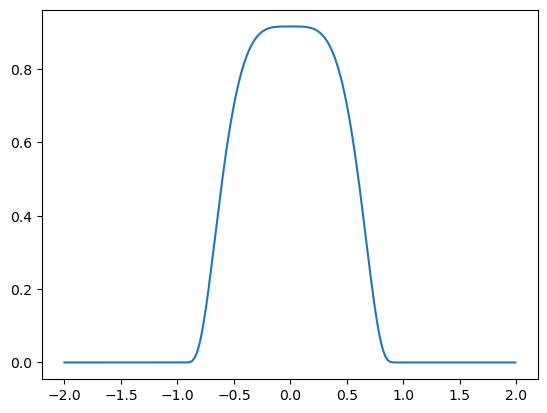

In [2]:
def F(x):
    if abs(x) >= 1.:
        return 0
    else:
        z = np.abs(x**2)
        return 50 * np.exp(-1.0 / ((0.5 - z/2)* (z/2 + 0.5)))

x = np.arange(-2, 2, 0.01)
y = [F(z) for z in x]

plt.plot(x, y)

In [3]:
def add_minimum(cx, cy, D, G1, rmax = 0.03):
    for i in range(G1.shape[0]):
        for j in range(G1.shape[1]):
            x, y = i/64.0, j/64.0
            r = (x-cx)**2 + (y-cy)**2
            if r < rmax:
                G1[i, j] += -exp(-r/D) / pow(2 * D, 0.5) * F(r/rmax)

In [4]:
G1 = torch.zeros((64, 64), dtype = torch.float64)

add_minimum(0.25, 0.25, 0.005, G1, rmax = 0.05)
add_minimum(0.25, 0.75, 0.01, G1, rmax = 0.05)
add_minimum(0.75, 0.25, 0.02, G1, rmax = 0.05)
#add_minimum(0.75, 0.75, 0.04, G1, rmax = 0.05)

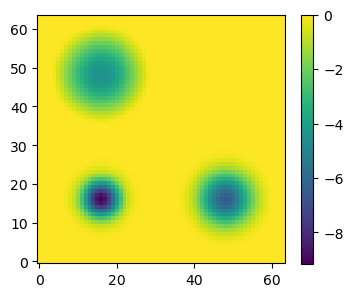

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(4, 4))

plt.imshow(G1.numpy(), cmap = 'viridis', origin = 'lower')
plt.colorbar(ax = ax, shrink = 0.81)

In [6]:
G2 = torch.zeros((64, 64), dtype = torch.float64)

add_minimum(0.25, 0.25, 0.005, G2, rmax = 0.05)
add_minimum(0.25, 0.75, 0.01, G2, rmax = 0.05)
#add_minimum(0.75, 0.25, 0.02, G2,rmax = 0.05)
add_minimum(0.75, 0.75, 0.02, G2, rmax = 0.05)

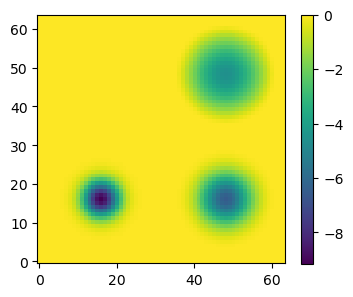

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(4, 4))

plt.imshow(G2.numpy(), cmap = 'viridis', origin = 'lower')
plt.colorbar(ax = ax, shrink = 0.81)

### SFTD Loss

In [8]:
sftd_loss = SFTDLossGudhi(dims = [0, 1, 2])

In [9]:
sftd_loss(G1, G2)

tensor(4.5789, dtype=torch.float64)

In [10]:
pers0 = sftd_loss.cubical_complex.persistence_intervals_in_dimension(0)
pers1 = sftd_loss.cubical_complex.persistence_intervals_in_dimension(1)

In [11]:
pers0

array([[-4.57890972,  0.        ],
       [-9.15781944,         inf]])

In [12]:
pers1

array([], shape=(0, 2), dtype=float64)

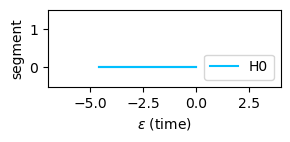

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-7.0, 4.0)
fig.set_size_inches((3, 1))

plot_barcodes(np.array([pers0, pers1], dtype = object))

### Regular barcodes

In [14]:
cubical_complex = gudhi.CubicalComplex(vertices = G1.numpy())
cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)

In [15]:
barc0 = cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
barc1 = cubical_complex.persistence_intervals_in_dimension(1)

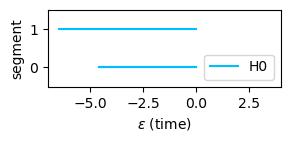

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-7.0, 4.0)
fig.set_size_inches((3, 1))

plot_barcodes([barc0, barc1])

### Visualization

In [17]:
def get_elem(D_shape, num):
    i1 = num // (D_shape[0] * D_shape[1])
    num -= i1 * D_shape[0] * D_shape[1]
    i2 = num // D_shape[0]
    num -= i2 * D_shape[0]
    i3 = num

    return i3, i2, i1

In [18]:
def add_markers(ax, dim = 0, layer = 0):
    for idx, (v1, v2) in enumerate(sftd_loss.v[0][dim]):
            print(v1, v2, get_elem(sftd_loss.D.shape, v1), get_elem(sftd_loss.D.shape, v2))
            markers = ['o', 'x', '*', 's', 'p']
            
            i1, i2, i3 = get_elem(sftd_loss.D.shape, v1)
            j1, j2, j3 = get_elem(sftd_loss.D.shape, v2)
            
            ax.plot(i3, i2, markers[0], color = 'orange', markersize = 10)
            ax.plot(j3, j2, markers[0], color = 'red', markersize = 10)

9360 6474 (0, 48, 48) (0, 46, 33)
3216 330 (0, 48, 16) (0, 46, 1)


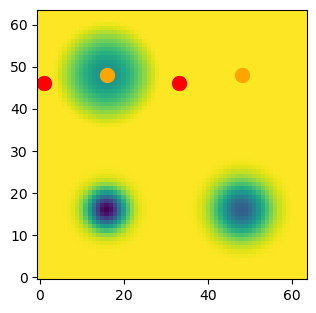

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(3.5, 3.5))
ax.imshow(G1.numpy(), cmap = 'viridis', origin = 'lower')

sftd_loss(G1, G2)
add_markers(ax, dim = 0)

sftd_loss(G2, G1)
add_markers(ax, dim = 0)